In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset

import torch
import os
import re
import random
from collections import defaultdict
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(42)

In [3]:
class_labels = ["anger", "disgust", "fear", "joy", "sadness", "surprise", "neutral"]

# Загрузка данных
data = load_dataset("csv", data_files={
    "train": "data/train_extended2.csv",
    "validation": "data/valid.csv"
})


# Функция для очистки текста
def cleaner(example):
    example["text"] = example["text"].lower()
    example["text"] = re.sub(r"[^a-zа-я\d]", " ", example["text"])
    example["text"] = re.sub(r"\s+", " ", example["text"])
    example["text"] = example["text"].strip()
    return example


# Применяем очистку
data = data.map(cleaner)


# Функция для преобразования one-hot меток
def one_hot_to_list(example):
    example["labels"] = [float(example[emotion]) for emotion in class_labels]
    return example


data = data.map(one_hot_to_list)


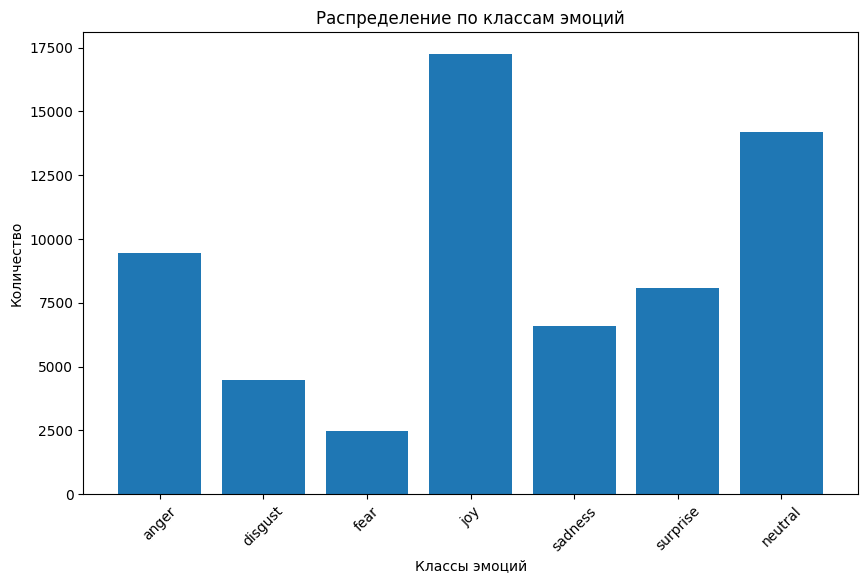

In [4]:
def plot_histogram(data_split):
    class_counts = defaultdict(int)
    for sample in data_split:
        for emotion in class_labels:
            class_counts[emotion] += sample["labels"][class_labels.index(emotion)]

    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts)
    plt.xlabel('Классы эмоций')
    plt.ylabel('Количество')
    plt.title('Распределение по классам эмоций')
    plt.xticks(rotation=45)
    plt.show()


plot_histogram(data["train"])


In [5]:
BASE_MODEL = "ai-forever/ru-en-RoSBERTa"
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
max_len = 64


def tokenize_function(examples):
    return tokenizer(examples["text"],
                     truncation=True,
                     padding="max_length",
                     max_length=max_len)


data = data.map(tokenize_function, batched=True)


Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

In [6]:
# Удаляем ненужные колонки и оставляем только необходимые
data = data.remove_columns(['text'])

# Устанавливаем формат данных для PyTorch
data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])


In [7]:
model = AutoModelForSequenceClassification.from_pretrained(
    BASE_MODEL,
    num_labels=len(class_labels),
    problem_type="multi_label_classification"
)


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at intfloat/multilingual-e5-large-instruct and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
def compute_metrics(pred):
    logits, labels = pred
    predictions = torch.sigmoid(torch.tensor(logits)).numpy()
    predictions = (predictions >= 0.5).astype(int)

    results = {}
    for i, label in enumerate(class_labels):
        results[f"f1_{label}"] = metrics.f1_score(labels[:, i], predictions[:, i], zero_division=0)
        results[f"precision_{label}"] = metrics.precision_score(labels[:, i], predictions[:, i], zero_division=0)
        results[f"recall_{label}"] = metrics.recall_score(labels[:, i], predictions[:, i], zero_division=0)

    # Общие метрики
    results["f1_macro"] = metrics.f1_score(labels, predictions, average='macro', zero_division=0)
    results["f1_micro"] = metrics.f1_score(labels, predictions, average='micro', zero_division=0)

    return results


In [10]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=1e-5,
    weight_decay=0.0,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro", # eval_loss
    greater_is_better=True,
    fp16=True,
)


In [11]:
from transformers import EarlyStoppingCallback

early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=2)

In [12]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data["train"],
    eval_dataset=data["validation"],
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]
)

In [13]:
trainer.train()


Epoch,Training Loss,Validation Loss,F1 Anger,Precision Anger,Recall Anger,F1 Disgust,Precision Disgust,Recall Disgust,F1 Fear,Precision Fear,Recall Fear,F1 Joy,Precision Joy,Recall Joy,F1 Sadness,Precision Sadness,Recall Sadness,F1 Surprise,Precision Surprise,Recall Surprise,F1 Neutral,Precision Neutral,Recall Neutral,F1 Macro,F1 Micro
1,0.314900,0.249622,0.519501,0.589381,0.464435,0.456274,0.361446,0.618557,0.606061,0.645161,0.571429,0.771993,0.895833,0.678233,0.591885,0.553571,0.635897,0.517269,0.518519,0.516026,0.473602,0.753086,0.345413,0.562369,0.609261
2,0.250000,0.226553,0.449524,0.708709,0.329149,0.469945,0.500000,0.443299,0.625592,0.622642,0.628571,0.803157,0.855759,0.756647,0.626016,0.663793,0.592308,0.519214,0.555759,0.487179,0.623802,0.686862,0.571348,0.588179,0.662643
3,0.238100,0.239745,0.567082,0.562414,0.571827,0.471616,0.409091,0.556701,0.632812,0.536424,0.771429,0.788650,0.862493,0.726453,0.626598,0.625000,0.628205,0.509982,0.587866,0.450321,0.592617,0.700386,0.513590,0.598480,0.654870
4,0.207500,0.267960,0.548483,0.478216,0.642957,0.456274,0.361446,0.618557,0.616000,0.531034,0.733333,0.766159,0.858501,0.691753,0.616687,0.583524,0.653846,0.509772,0.518212,0.501603,0.543915,0.721235,0.436580,0.579613,0.626093
5,0.190400,0.270597,0.559627,0.535714,0.585774,0.470990,0.352041,0.711340,0.645161,0.559441,0.761905,0.790106,0.845758,0.741325,0.617225,0.578475,0.661538,0.508501,0.491045,0.527244,0.556909,0.722674,0.453001,0.592645,0.642519


TrainOutput(global_step=17990, training_loss=0.2496703898529002, metrics={'train_runtime': 3406.6844, 'train_samples_per_second': 168.985, 'train_steps_per_second': 10.562, 'total_flos': 3.353145692166144e+16, 'train_loss': 0.2496703898529002, 'epoch': 5.0})

In [14]:
eval_results = trainer.evaluate()
print(eval_results)


{'eval_loss': 0.23974519968032837, 'eval_f1_anger': 0.5670816044260027, 'eval_precision_anger': 0.5624142661179699, 'eval_recall_anger': 0.5718270571827058, 'eval_f1_disgust': 0.47161572052401746, 'eval_precision_disgust': 0.4090909090909091, 'eval_recall_disgust': 0.5567010309278351, 'eval_f1_fear': 0.6328125, 'eval_precision_fear': 0.5364238410596026, 'eval_recall_fear': 0.7714285714285715, 'eval_f1_joy': 0.7886497064579256, 'eval_precision_joy': 0.8624933119315141, 'eval_recall_joy': 0.7264533573681838, 'eval_f1_sadness': 0.6265984654731458, 'eval_precision_sadness': 0.625, 'eval_recall_sadness': 0.6282051282051282, 'eval_f1_surprise': 0.5099818511796733, 'eval_precision_surprise': 0.5878661087866108, 'eval_recall_surprise': 0.45032051282051283, 'eval_f1_neutral': 0.5926167918980725, 'eval_precision_neutral': 0.7003861003861004, 'eval_recall_neutral': 0.513590033975085, 'eval_f1_macro': 0.5984795199941197, 'eval_f1_micro': 0.6548704852243706, 'eval_runtime': 7.7057, 'eval_samples_pe

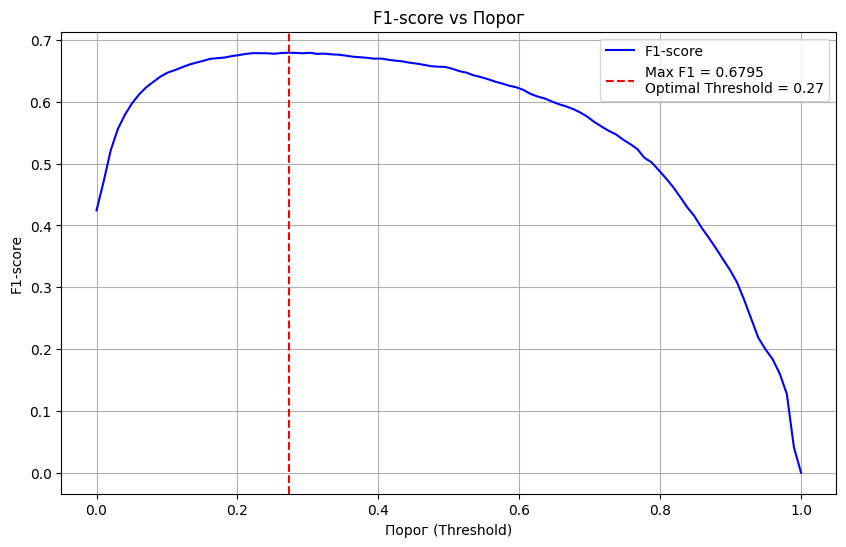

Оптимальный порог: 0.27 с F1-score: 0.6795


In [15]:
# Получаем прогнозы на валидационной выборке
val_predictions = trainer.predict(data["validation"])
val_logits = val_predictions.predictions
val_labels = val_predictions.label_ids

# Применяем sigmoid
val_probs = torch.sigmoid(torch.tensor(val_logits)).numpy()

# Диапазон порогов
edges = np.linspace(0, 1, 100)
f1_scores = []

for edge in edges:
    preds = (val_probs >= edge).astype(int)
    f1 = metrics.f1_score(val_labels, preds, average='weighted', zero_division=0)
    f1_scores.append(f1)

# Находим оптимальный порог
max_f1 = max(f1_scores)
optimal_edge = edges[np.argmax(f1_scores)]

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(edges, f1_scores, label="F1-score", color="blue")
plt.xlabel("Порог (Threshold)")
plt.ylabel("F1-score")
plt.title("F1-score vs Порог")
plt.axvline(optimal_edge, color='red', linestyle='--',
            label=f"Max F1 = {max_f1:.4f} \nOptimal Threshold = {optimal_edge:.2f}")
plt.legend()
plt.grid()
plt.show()

print(f"Оптимальный порог: {optimal_edge:.2f} с F1-score: {max_f1:.4f}")


In [16]:
# Загрузка тестовых данных
test = load_dataset("csv", data_files={"test": "data/test_without_answers.csv"})

# Очистка и токенизация
test = test.map(cleaner)
test = test.map(one_hot_to_list)
test = test.map(tokenize_function, batched=True)
test = test.remove_columns(['text'])
test.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Получение прогнозов
test_predictions = trainer.predict(test["test"])
test_logits = test_predictions.predictions
test_probs = torch.sigmoid(torch.tensor(test_logits)).numpy()

# Применяем оптимальный порог
test_outputs = (test_probs >= optimal_edge).astype(int)

# Подготовка сабмита
df = pd.read_csv("data/test_without_answers.csv")
df.insert(loc=0, column='id', value=np.arange(1, len(df) + 1))
df = df.drop(['text'], axis=1)
df[class_labels] = test_outputs
df.to_csv("outputs/submission_trainer.csv", index=False)
print("Сабмит сохранён в outputs/submission_trainer.csv")


Map:   0%|          | 0/8742 [00:00<?, ? examples/s]

Сабмит сохранён в data/submission_trainer.csv
